In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

In [2]:
token = '' # Put in your IBM token
IBMQ.save_account(token, overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')

In [3]:
backend_sims = ["ibmq_qasm_simulator", "simulator_statevector"]
backends = ["ibmq_manila", "ibmq_quito", "ibmq_belem", "ibmq_lima", "ibm_oslo", "ibm_nairobi"]

job_manager = IBMQJobManager()
backend = provider.get_backend(backends[5]) # Either use backend_sim for simulator, or backends[x] for device
print(backend)

ibm_nairobi


In [4]:
def apply_Utheta(qc, qubit, theta):
    """
    Applies U(theta) = cos(theta)|0><0| + sin(theta)|0><1| - sin(theta)|1><0| + cos(theta)|1><1| to specified qubit in quantum circuit
    Inputs: qc - quantum circuit
            qubit - qubit in quantum circuit to apply U(theta) to
            theta - variational parameter
    Outputs: None
    """
    U = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    gate_label = "Utheta"
    qc.unitary(U, qubit, label = gate_label)

def generate_onequbit_circuit(theta, Xbasis):
    """
    Generates the VQE circuit |+/0>-[U]-||Z for <Xi> and <Ki> measurements.
    Inputs: theta - variational parameter
            Xbasis - whether the qubit is a Pauli-X eigenstate, or Pauli-Z eigenstate
    Outputs: The 1-qubit VQE circuit
    """
    # Initializes circuit
    qr = QuantumRegister(1)
    qc = QuantumCircuit(qr)
    
    
    if Xbasis:
        # Set |0> to |+> (if want to make it an X-eigenstate)
        qc.h(0)

    # Apply U(theta) to qubit
    apply_Utheta(qc, 0, theta)

    # Measure in comp. basis
    qc.measure_all()

    return qc

def generate_twoqubit_circuit(theta, z0, z1):
    """
    Generates the VQE circuit |+> -.-[Z^{z0}]-[U]-||Z
                                   |
                              |+> -.-[Z^{z1}]-[H]-[U]-||Z
    Inputs: theta - variational parameter
            z0 - apply Z gate on first qubit
            z1 - apply Z gate on second qubit
    Outputs: The 1-qubit VQE circuit
    """
    # Initializes circuit
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)
    
    qc.h(0)
    qc.h(1)
    qc.cz(0, 1)

    if z0:
        qc.z(0)
    if z1:
        qc.z(1)
    
    qc.h(1)

    apply_Utheta(qc, 0, theta)
    apply_Utheta(qc, 1, theta)

    qc.measure_all()

    return qc


def perform_onequbit(backend, best_qubits, shots_num, job_manager, theta, meas_filter = 0):
    """
    Performs one-qubit circuits for <Xi> and <Ki> VQE calculations
    Input: backend - Which backend (simulator or device) to use
           best_qubits - which (1) qubits to use on the backend
           shots_num - how many shots per experiment
           job_manager - IBMQ jobmanager
           theta - VQE parameter.
           meas_filter - One-qubit measurement error mitigation filter; by default is not applied.
    """
    qc_trans = transpile([generate_onequbit_circuit(theta, True), generate_onequbit_circuit(theta, False), generate_onequbit_circuit(theta, True)], backend=backend, initial_layout=best_qubits)
    job_exp = job_manager.run(qc_trans, backend=backend, shots=shots_num, name='VQEonequbit')
    for i in range(len(job_exp.jobs())):
        job_monitor(job_exp.jobs()[i])
    print('All jobs have finished.')
    
    results = job_exp.results()
    countsX = results.get_counts(0)
    countsXZedge = results.get_counts(1)
    countsZXZbulk = results.get_counts(2)
    
    if meas_filter != 0:
        countsX = meas_filter.apply(countsX)
        countsXZedge = meas_filter.apply(countsXZedge)
        countsZXZbulk = meas_filter.apply(countsZXZbulk)

    return countsX, countsXZedge, countsZXZbulk

def perform_twoqubits(backend, best_qubits, shots_num, job_manager, theta, meas_filter=0):

    qc_trans = transpile([generate_twoqubit_circuit(theta, False, False), generate_twoqubit_circuit(theta, True, False), generate_twoqubit_circuit(theta, False, True), generate_twoqubit_circuit(theta, True, True)], backend=backend, initial_layout=best_qubits)

    job_exp = job_manager.run(qc_trans, backend=backend, shots=shots_num, name='VQEtwoqubit')
    for i in range(len(job_exp.jobs())):
        job_monitor(job_exp.jobs()[i])
    print('All jobs have finished.')
    
    results = job_exp.results()
    counts00 = results.get_counts(0)
    counts10 = results.get_counts(1)
    counts01 = results.get_counts(2)
    counts11 = results.get_counts(3)
    
    if meas_filter != 0:
        counts00 = meas_filter.apply(counts00)
        counts10 = meas_filter.apply(counts10)
        counts01 = meas_filter.apply(counts01)
        counts11 = meas_filter.apply(counts11)

    return counts00, counts10, counts01, counts11

def nonecheck(count):
    if count is None:
        return 0
    else:
        return int(count)

def Xprocess(counts):
    plus = nonecheck(counts.get("0"))
    minus = nonecheck(counts.get("1"))
    
    return (plus - minus)/(plus + minus)

def parityprob(counts):
    counts00 = nonecheck(counts.get("00"))
    counts01 = nonecheck(counts.get("01"))
    counts10 = nonecheck(counts.get("10"))
    counts11 = nonecheck(counts.get("11"))

    evenprob = (counts00 + counts11)/(counts00 + counts11 + counts10 + counts01)
    return evenprob

def ZXZprocess(s3counts, countsII, countsZI, countsIZ, countsZZ):
    s3zero = nonecheck(s3counts.get("0"))
    s3one = nonecheck(s3counts.get("1"))

    countsIIevenprob = parityprob(countsII)
    countsZIevenprob = parityprob(countsZI)
    countsIZevenprob = parityprob(countsIZ)
    countsZZevenprob = parityprob(countsZZ)

    plus = 0
    minus = 0

    for i in range(s3zero):
        rand1 = np.random.rand()
        rand2 = np.random.rand()
        if rand1 < 0.500:
            if rand2 < countsIIevenprob:
                plus += 1
            else:
                minus += 1
        else:
            if rand2 < countsZIevenprob:
                plus += 1
            else:
                minus += 1


    for i in range(s3one):
        rand1 = np.random.rand()
        rand2 = np.random.rand()
        if rand1 < 0.500:
            if rand2 < countsIZevenprob:
                minus += 1
            else:
                plus += 1
        else:
            if rand2 < countsZZevenprob:
                minus += 1
            else:
                plus += 1

    return (plus - minus)/(plus + minus)

def one_VQEpoint(backend, best_qubits_one, best_qubits_two, shots_num, job_manager, theta, meas_filter_one=0, meas_filter_two=0):
    countsX, countsXZedge, countsZXZbulk = perform_onequbit(backend, best_qubits_one, shots_num, job_manager, theta, meas_filter_one)
    countsII, countsZI, countsIZ, countsZZ = perform_twoqubits(backend, best_qubits_two, shots_num, job_manager, theta, meas_filter_two)

    avgX = Xprocess(countsX)
    avgXZedge = Xprocess(countsXZedge)
    avgZXZbulk = ZXZprocess(countsZXZbulk, countsII, countsZI, countsIZ, countsZZ)

    return avgX, avgXZedge, avgZXZbulk

In [5]:
# Measurement error calibrations
def run_meas_error_calibs(backend, best_qubits, shots_num):
    """
    Runs measurement error calibration circuits and returns a measurement error mitigation filter
    Inputs: backend - Which backend (simulator or device) to use
           best_qubits - which qubits to use on the backend
           shots_num - how many shots per experiment
    Outputs: meas_filter - Measurement error mitigation filter based on calibrations
    """
    qc_err = qiskit.QuantumRegister(len(best_qubits))
    meas_calibs, state_labels = complete_meas_cal(qr=qc_err, circlabel='mcal')
    meas_calibs = transpile(meas_calibs, backend=backend, initial_layout=best_qubits)
    job_err = qiskit.execute(meas_calibs, backend=backend, shots=shots_num)
    job_monitor(job_err)
    cal_result = job_err.result()
    meas_fitter = CompleteMeasFitter(cal_result, state_labels, circlabel='mcal')
    meas_filter = meas_fitter.filter
    return meas_filter

In [6]:
def Xedge_analytic(theta):
    return 0

def Xbulk_analytic(theta):
    x = np.sin(2 * theta)
    return x

def XZedge_analytic(theta):
    x = np.sin(2 * theta)
    return np.sqrt(1-x**2)

def ZXZbulk_analytic(theta):
    x = np.sin(2 * theta)
    return 1-x**2

In [8]:
best_one_qubit = [1]
best_two_qubits = [1, 2]
shots_num = 8000

Xbulk_ar = []
XZedge_ar = []
ZXZbulk_ar = []

In [9]:
theta_ar = np.linspace(0, np.pi/4, 100)

In [16]:
meas_filter_one = run_meas_error_calibs(backend, best_one_qubit, shots_num)

Job Status: job has successfully run


In [17]:
meas_filter_two = run_meas_error_calibs(backend, best_two_qubits, shots_num)

Job Status: job has successfully run


In [18]:
for theta in theta_ar:
    Xbulk, XZedge, ZXZbulk = one_VQEpoint(backend, best_one_qubit, best_two_qubits, shots_num, job_manager, theta, meas_filter_one, meas_filter_two)
    Xbulk_ar.append(Xbulk)
    XZedge_ar.append(XZedge)
    ZXZbulk_ar.append(ZXZbulk)

Job Status: job has successfully run
All jobs have finished.
Job Status: job has successfully run
All jobs have finished.
Job Status: job has successfully run
All jobs have finished.
Job Status: job has successfully run
All jobs have finished.
Job Status: job has successfully run
All jobs have finished.
Job Status: job has successfully run
All jobs have finished.
Job Status: job has successfully run
All jobs have finished.
Job Status: job has successfully run
All jobs have finished.
Job Status: job has successfully run
All jobs have finished.
Job Status: job has successfully run
All jobs have finished.
Job Status: job has successfully run
All jobs have finished.
Job Status: job has successfully run
All jobs have finished.
Job Status: job has successfully run
All jobs have finished.
Job Status: job has successfully run
All jobs have finished.
Job Status: job has successfully run
All jobs have finished.
Job Status: job has successfully run
All jobs have finished.
Job Status: job has succ

IBMQJobApiError: '"HTTPSConnectionPool(host=\'api.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q/Groups/open/Projects/main/Jobs/63c899b0fc580541f9f5b245/status/v/1 (Caused by NewConnectionError(\'<urllib3.connection.HTTPSConnection object at 0x7fa76971eaf0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known\'))"'

In [138]:
np.savetxt(".csv", Xbulk_ar)
np.savetxt(".csv", XZedge_ar)
np.savetxt(".csv", ZXZbulk_ar)

In [142]:
def E(alpha):
    product = -np.sin(alpha)*(3*np.array(Xbulk_ar))
    cluster = -np.cos(alpha)*(4*np.array(XZedge_ar) + np.array(ZXZbulk_ar))
    return product + cluster

In [143]:
alpha = 0
indexmin = np.argmin(E(alpha))
print(theta_ar[indexmin]) # variaitonal parameter theta that minimizes the energy
print(XZedge_ar[indexmin]) # SOP

0.0
1.0


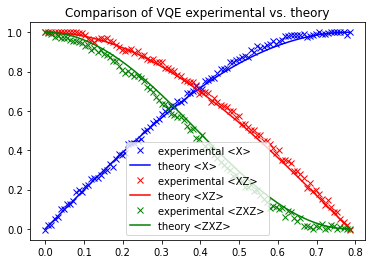

In [140]:
plt.plot(theta_ar, Xbulk_ar, "bx", label="experimental <X>")
plt.plot(theta_ar, 2*np.sin(theta_ar)*np.cos(theta_ar), "b-", label="theory <X>")
plt.plot(theta_ar, XZedge_ar, "rx", label="experimental <XZ>")
plt.plot(theta_ar, np.sqrt(1-(2*np.sin(theta_ar)*np.cos(theta_ar))**2), "r-", label="theory <XZ>")
plt.plot(theta_ar, ZXZbulk_ar, "gx", label="experimental <ZXZ>")
plt.plot(theta_ar, 1-(2*np.sin(theta_ar)*np.cos(theta_ar))**2, "g-", label="theory <ZXZ>")
plt.title("Comparison of VQE experimental vs. theory")
plt.legend()
#plt.savefig("VQEexperimenttheory.pdf")
plt.show()